In [1]:
import numpy as np
import pandas as pd
import torch 
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style_2.txt')
import sys
sys.path.insert(0,'/home/gridsan/gschuette/ChromoGen/src/data_utils/SampleClass/')
from Coordinates import Coordinates

In [2]:
full_genome_save_dir = Path('./full_genome_dcd/')
bintu_save_dir = Path('./bintu_data/')

full_genome_save_dir.mkdir(parents=True,exist_ok=True)
bintu_save_dir.mkdir(parents=True,exist_ok=True)

#### Functions to load the raw Tan data

In [3]:
def load_coords(filepath):
    '''
    Assumes Dip-C 3dg format
    '''
    coord_df = pd.read_csv(
        filepath,
        sep='\t',
        header=None,
        names=['Chromosome','Genomic_Index','x','y','z']
    )

    return coord_df

def separate_lineage(coord_df):

    # Define lineages in their own column for easy access
    coord_df['Lineage'] = [k[-4:-1] for k in coord_df['Chromosome']]

    # Reduce the chromosome column to just the chromosome number
    # (or X/Y, where relevant)
    coord_df['Chromosome'] = [ k[:-5] for k in coord_df['Chromosome']]

    # Place lineage in the first position
    col_order = coord_df.columns.tolist()[:-1]
    col_order.insert(0,'Lineage')
    coord_df = coord_df[col_order]

    return coord_df

def sort_coord_df(coord_df):
    '''
    Want all maternal to come before all paternal bead locations.
    Within mat/pat chromosomes, want chromosome order 1,2,...,22,X,Y.
    Within each chromosome, want bead location to be sequential.
    '''

    # Must make single-digit numbers equal to f'0{number}' to get the
    # desired sorting of chromosome numbers.
    vals = {str(k):'0'+str(k) for k in range(1,10)}
    coord_df.replace({'Chromosome':vals},inplace=True)

    # Sort values with the described order of importance.
    coord_df.sort_values(
        by=['Lineage','Chromosome','Genomic_Index'],
        axis='index',
        inplace=True,
        ignore_index=True
    )

    # Remove the leading '0's where relevant.
    vals = {'0'+str(k):str(k) for k in range(1,10)}
    coord_df.replace({'Chromosome':vals},inplace=True)

def process_coord_data(coord_df):
    '''
    After loading data from the 3dg file, process the DataFrame
    so that it agrees with the data structure used to save 3D
    structures in a searchable HDF5 file containing 3D data
    from multiple organisms, cell types, chromosomes.
    '''

    # Remove all rows with nan values in any column, as
    # we have no use for these rows.
    '''
    coord_df.dropna(
        axis='index',
        inplace=True,
        ignore_index=True
    )
    '''
    # When the starting file contains NaNs or missing values, the
    # datatypes may not be what is expected. This function ensures
    # that they obey the standard construction.
    coord_df = coord_df.astype({
        'Chromosome':str,
        'Genomic_Index':np.int64,
        'x':np.float64,
        'y':np.float64,
        'z':np.float64
    })

    # Certain data files downloaded from the GEO database contain
    # duplicated data, so we must remove these duplicates.
    coord_df.drop_duplicates(inplace=True,keep='first',ignore_index=True)

    # Convert Chromosome information from f"{chrom}({lineage})" to
    # f"{chrom}" and create a new column to track the lineage.
    coord_df = separate_lineage(coord_df)

    # Want all maternal to come before all paternal bead locations.
    # Within mat/pat copies, want chromosome order 1,2,...,22,X,Y.
    # Within each chromosome, want bead location to be sequential.
    sort_coord_df(coord_df)

    return coord_df

coords = process_coord_data(load_coords(
    #'/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/tan_single-cell_2018/Supp_GSM3271347_GM12878_Cell_1/GSM3271347_gm12878_01.impute.3dg.txt.gz'
    '/home/gridsan/gschuette/refining_scHiC/revamp_with_zhuohan/data/tan_single-cell_2018/Supp_GSM3271347_GM12878_Cell_1/GSM3271347_gm12878_01.impute3.round4.3dg.txt.gz'
))

#### Function to create topology files

In [4]:
def atoms(n_monomers):
    lines = [
        str(n_monomers).rjust(8) + ' !NATOM'
    ]
    lines+= [
        str(k).rjust(8) + ' POL  1    POL  C    C    0.0           0.0                  0           0.0' for k in range(n_monomers)
    ]
    return lines

def bonds(n_monomers):
    f = lambda x: str(x).rjust(8)
    lines = [f(n_monomers-1)+' !NBOND: bonds']
    line = f(1) + f(2)
    mon = 2
    mon_before = False
    n = 2
    while mon < n_monomers:
        # Show each of the monomers twice
        if mon_before:
            mon+=1
            mon_before = False
        else:
            mon_before = True
        if n == 8:
            lines.append(line)
            line=''
            n=0
        line+= f(mon)
        n+=1
    if line:
        lines.append(line)
    return lines

def create_psf(n_monomers,filepath):

    lines = [
        'PSF CMAP CHEQ XPLOR',
        '',
        '       1 !NTITLE',
        '* HOMOPOLYMER PSF FILE',
        '',
        ''
    ]
    lines+= atoms(n_monomers)
    lines.append('')
    lines+= bonds(n_monomers)
    lines+= [
       '',
       '0 !NTHETA: angles',
       '',
       '',
       '0 !NPHI: dihedrals',
       '',
       '',
       '0 !NIMPHI: impropers',
       ''
    ]
    open(filepath,'w').write('\n'.join(lines))


In [5]:
for lin in ['mat','pat']:
    c = coords[coords.Lineage == lin]
    for chrom in c.Chromosome.unique():
        if (full_genome_save_dir / f'{chrom}_{lin}.dcd').is_file() and (full_genome_save_dir / f'{chrom}_{lin}.psf').is_file():
            continue
        c1 = Coordinates(c[c.Chromosome == chrom][['x','y','z']].values)
        c1.trajectory.save_dcd(full_genome_save_dir / f'{chrom}_{lin}.dcd')
        create_psf(c1.num_beads, full_genome_save_dir / f'{chrom}_{lin}.psf')


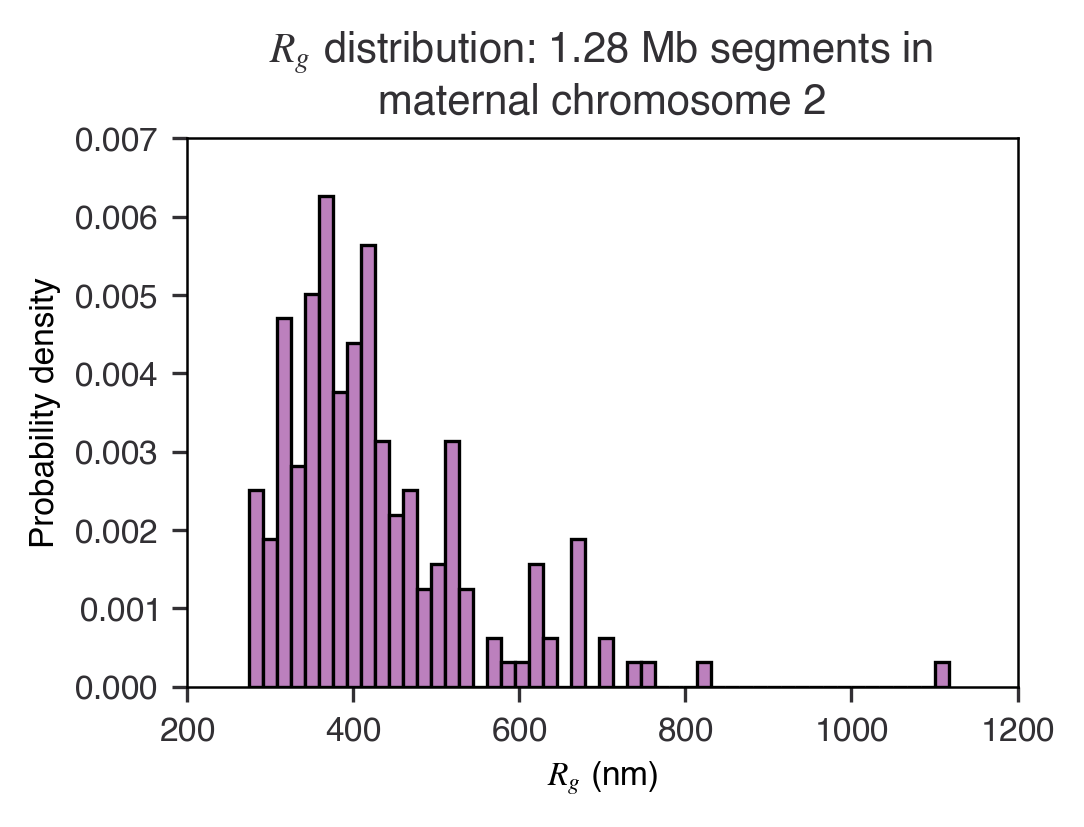

In [6]:
import matplotlib.pyplot as plt
c = coords[coords.Lineage == 'mat']
c = c[c.Chromosome == '2']
c = Coordinates(c[['x','y','z']].values)
c1 = c[:,:64,:]
i = 64
j = 128
while j < c.num_beads:
    c1 = c1.append(c[:,i:j,:])
    i=j
    j+=64

fig,ax = plt.subplots(ncols=1,nrows=1,layout='constrained',figsize=(3.5,2.6407))
r_gs = c1.compute_rg().flatten()
ax.hist(r_gs.numpy() * 100,bins=50,density=True)
ax.set_xlim([200,1200])
ax.set_xlabel('$R_g$ (nm)')
ax.set_ylabel('Probability density')
ax.set_title('$R_g$ distribution: 1.28 Mb segments in \nmaternal chromosome 2')#f'(overall $R_g={round(float(c.compute_rg()*100))}$ nm)')

fig.savefig('./figures/r_g_hist_mat_2.pdf',bbox_inches='tight')

In [7]:
r_gs1 = r_gs.sort()

In [8]:
for i in [-1,-2,-3,-4,0,1,2,len(r_gs1.indices)//2, len(r_gs1.indices)//2 + 1]:
    print(i, r_gs1.indices[i] * 64, r_gs1.indices[i] * 64 + 63, r_gs1.values[i])

-1 tensor(4608) tensor(4671) tensor(11.1785)
-2 tensor(4736) tensor(4799) tensor(8.1827)
-3 tensor(4544) tensor(4607) tensor(7.4893)
-4 tensor(4480) tensor(4543) tensor(7.3507)
0 tensor(6720) tensor(6783) tensor(2.7394)
1 tensor(512) tensor(575) tensor(2.7563)
2 tensor(8000) tensor(8063) tensor(2.8059)
94 tensor(8512) tensor(8575) tensor(4.0171)
95 tensor(11584) tensor(11647) tensor(4.0372)


In [9]:
len(r_gs1.values)

189

In [10]:
r_gs1.indices[-2] * 64, r_gs1.values[-2]

(tensor(4736), tensor(8.1827))

In [11]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm
def max_dist(i,coords=torch.from_numpy(coords[['x','y','z']].values)):
    return torch.cdist(coords[...,i:i+1,:], coords[...,i+1:,:]).max()
    
with ThreadPoolExecutor() as executor:
    maxes = [
        executor.submit(max_dist,i) for i in range(len(coords)-1)
    ]
    max_dist = max(future.result() for future in tqdm(maxes))
    del maxes
max_dist

  0%|          | 0/269867 [00:00<?, ?it/s]

tensor(127.1003, dtype=torch.float64)

#### Bintu data

In [6]:
import torch
import pandas as pd
import sys
sys.path.insert(0,'/home/gridsan/gschuette/ChromoGen/src/data_utils/SampleClass/')
from Coordinates import Coordinates

def process_bintu(filepath):

    df = pd.read_csv(
        filepath,
        header=1
    )

    dfs = []
    if 'Cell cycle' in df:
        for cc in df['Cell cycle'].unique():
            dfs.append(df[df['Cell cycle']==cc])
    else:
        dfs.append(df)

    conformations = []
    for df in dfs:
        xyz = df[['X','Y','Z']]
        conformations.extend([ # pandas errantly converts the stored ints to np.float64's -> torch.double's. More convenient to have floats anyway, but use 32 bit for storage space
            torch.from_numpy(xyz[df['Chromosome index']==idx].values).float().unsqueeze(0) for idx in df['Chromosome index'].unique()
        ])
    coords = Coordinates(conformations[0]).append(conformations[1:])
    coords.trajectory.save_dcd(filepath.replace('.csv','.dcd'))
    create_psf(coords.num_beads, filepath.replace('.csv','.psf'))

for fn in (bintu_save_dir / 'data_filenames.txt').open('r').readlines():
    if 'overlap' in fn:
        continue
    fn = fn.replace('%20','_').strip()
    process_bintu(str(bintu_save_dir / fn))



In [7]:
r_gs = []
n = 0
all_bintu_coords = []
for f1 in bintu_save_dir.rglob('*.pt'):
    f = str(f1) 
    #if 'IMR90' not in f:
    #    continue
    c = Coordinates(f)
    if c.num_beads < 43:
        continue
    all_bintu_coords.append(c)
    i = (c.num_beads - 43) // 2
    c = c[...,i:i+43,:]
    r_gs.append(c.compute_rg())
r_gs = torch.cat(r_gs) 

In [9]:
r_gs.isfinite().sum()

tensor(1050)

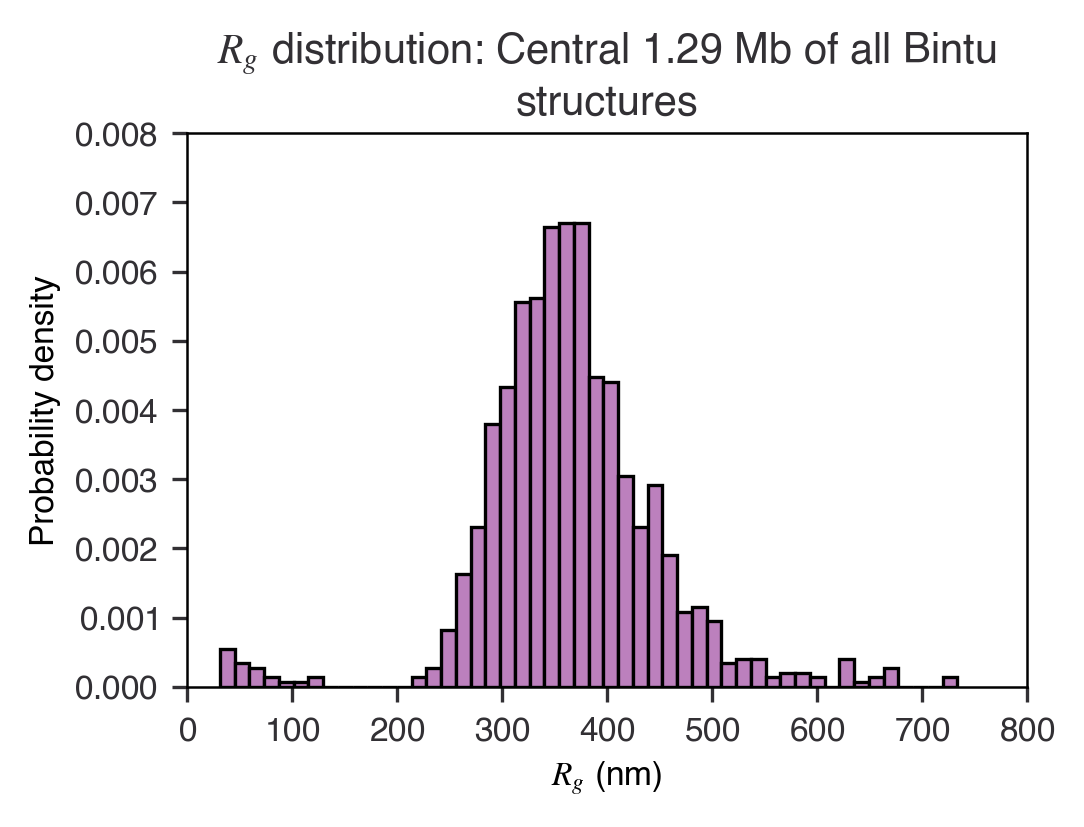

In [14]:
fig,ax = plt.subplots(ncols=1,nrows=1,layout='constrained',figsize=(3.5,2.6407))
ax.hist(r_gs.numpy(),bins=50,density=True)
ax.set_xlim([0,ax.get_xlim()[1]])
ax.set_xlabel('$R_g$ (nm)')
ax.set_ylabel('Probability density')
ax.set_title('$R_g$ distribution: Central 1.29 Mb of all Bintu structures',wrap=True)
fig.savefig('./figures/r_g_hist_Bintu.pdf',bbox_inches='tight')

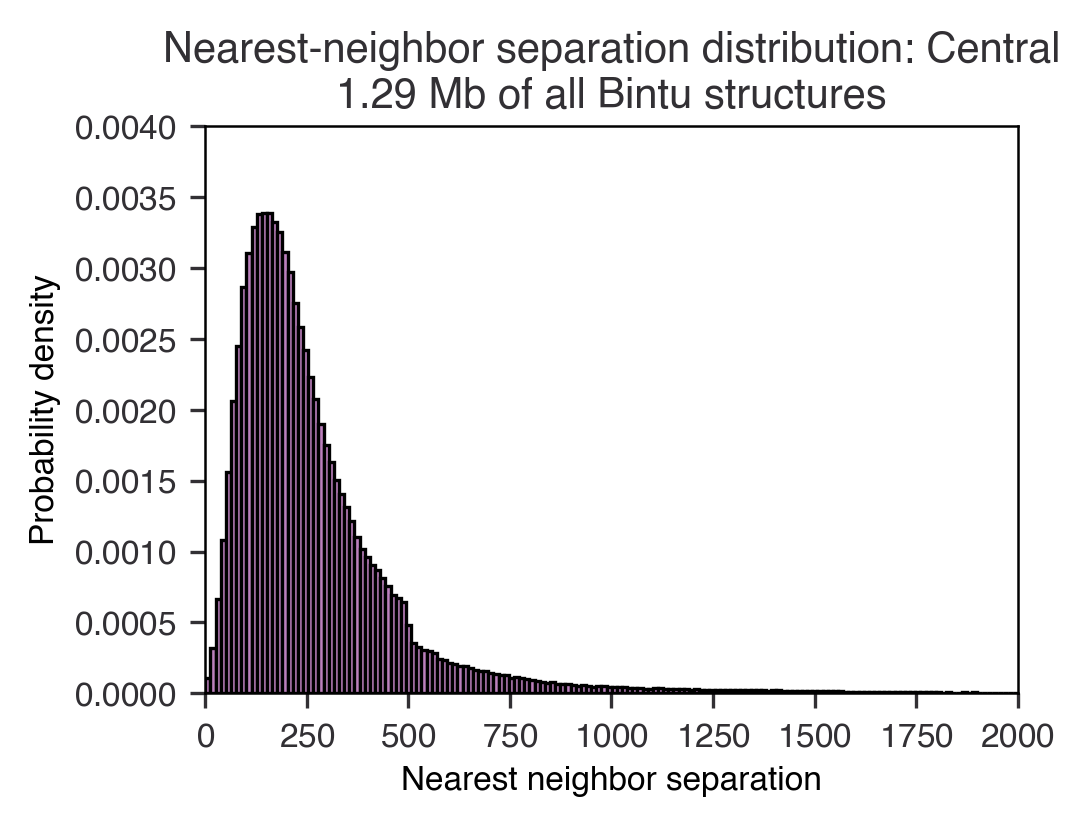

In [67]:
bond_dists = torch.cat([
    (c.values[:,1:,:]-c.values[:,:-1,:]).square_().sum(-1).sqrt_().flatten() for c in all_bintu_coords
])
bond_dists = bond_dists[bond_dists.isfinite()] #* (20/30)**(1/3)

fig,ax = plt.subplots(ncols=1,nrows=1,layout='constrained',figsize=(3.5,2.6407))
ax.hist(bond_dists.flatten().numpy(),bins=250,density=True)
ax.set_xlim([0,2000])
ax.set_xlabel('Nearest neighbor separation')
ax.set_ylabel('Probability density')
ax.set_title('Nearest-neighbor separation distribution: Central 1.29 Mb of all Bintu structures',wrap=True)
fig.savefig('./figures/dist_hist_Bintu.pdf',bbox_inches='tight')

In [66]:
bond_dists.max(), bond_dists.median(), bond_dists.mean()

(tensor(2766.2158), tensor(184.8526), tensor(234.1744))

In [ ]:
coords.num_beads